In [1]:
%load_ext autoreload
%autoreload 3

In [2]:
import logging
import sys

import numpy as np
import pandas as pd
import sqlalchemy as sa

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_validate, KFold, GridSearchCV
from sklearn.ensemble import HistGradientBoostingRegressor

import pudl
from pudl.output.pudltabl import PudlTabl
from pudl.metadata.fields import apply_pudl_dtypes
from pudl.metadata.enums import STATE_TO_CENSUS_REGION

In [3]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(stream=sys.stdout)
formatter = logging.Formatter("%(message)s")
handler.setFormatter(formatter)
logger.handlers = [handler]

matplotlib.rcParams["figure.figsize"] = (10, 4)
matplotlib.rcParams["figure.dpi"] = 150
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [4]:
pudl_settings = pudl.workspace.setup.get_defaults()
pudl_engine = sa.create_engine(pudl_settings["pudl_db"])

# Data Preparation and Preprocessing

## Read data from PUDL DB and create some features 

In [5]:
%%time

FRC_EIA923_DATA_COLS = [
    "plant_id_eia",
    "report_date",
    "energy_source_code",
    "fuel_cost_per_mmbtu",
    "fuel_received_units",
    "fuel_mmbtu_per_unit",
]

logger.info("Query PUDL DB and build some features.")
plant_states = pd.read_sql("SELECT plant_id_eia, state FROM plants_entity_eia", pudl_engine)
fuel_group_eiaepm = pd.read_sql("SELECT code AS energy_source_code, fuel_group_eiaepm FROM energy_sources_eia", pudl_engine)

frc = (
    pd.read_sql("fuel_receipts_costs_eia923", pudl_engine, columns=FRC_EIA923_DATA_COLS)
    .merge(plant_states, on="plant_id_eia", how="left", validate="many_to_one")
    # Fuel group also cleanly categorizes fuel units, making fuel_mmbtu_per_unit more sensible.
    .merge(fuel_group_eiaepm, on="energy_source_code", how="left", validate="many_to_one")
    .pipe(apply_pudl_dtypes, group="eia")
    .assign(
        # There's no such thing as a free MMBTU
        fuel_cost_per_mmbtu=lambda x: x.fuel_cost_per_mmbtu.replace(0.0, np.nan),
        # Numerical representation of elapsed time
        elapsed_days=lambda x: (x.report_date - x.report_date.min()).dt.days,
        # Categorical months, to capture cyclical seasonal variability
        report_month=lambda x: x.report_date.dt.month,
        # Larger geographic area more likely to have lots of records
        census_region=lambda x: x.state.map(STATE_TO_CENSUS_REGION),
        # Need the total MMBTU for weighting the importance of the record
        # May also be predictive -- small deliveries seem more likely to be expensive
        fuel_received_mmbtu=lambda x: x.fuel_received_units * x.fuel_mmbtu_per_unit,
    )
    .drop(columns=["report_date", "fuel_received_units"])
    .convert_dtypes(convert_floating=False)
)

# sklearn doesn't know how to deal with pandas nullable strings in categorical columns?
string_cols = frc.select_dtypes("string").columns
frc.loc[:, string_cols] = frc[string_cols].fillna("NULL")

Query PUDL DB and build some features.
CPU times: user 3.66 s, sys: 160 ms, total: 3.82 s
Wall time: 3.83 s


## Split the data into different functional parts...

In [6]:
# Records where we're missing the target value:
frc_to_predict = frc[frc.fuel_cost_per_mmbtu.isna()]

# Records where we have the target value:
frc_train_test = frc[frc.fuel_cost_per_mmbtu.notna()]

# The data we're going to use to predict:
frc_data = frc_train_test.drop(columns=["fuel_cost_per_mmbtu"])

# The target we're trying to predict:
frc_target = frc_train_test["fuel_cost_per_mmbtu"]

# Relative importance of each of the records:
sample_weight=frc_data["fuel_received_mmbtu"]

## Build a Pipeline

In [7]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [8]:
cat_cols = [
#   "plant_id_eia", 
    "report_month", 
#   "energy_source_code", 
    "fuel_group_eiaepm",
    "state", 
#   "census_region", 
]

num_cols = [
    "elapsed_days",
    "fuel_mmbtu_per_unit",
#   "fuel_received_mmbtu",
]

cat_pre = OrdinalEncoder(
    handle_unknown="use_encoded_value",
    unknown_value=-1,
)

pre = ColumnTransformer(
    [
        ("cat_pre", cat_pre, cat_cols),
    ],
    remainder="passthrough",
    sparse_threshold=0,
)
    
pipe = Pipeline([
    ("pre", pre),
    ("hist_gbr", HistGradientBoostingRegressor()),
])

## Train a Naive Model
* Before doing any model evaluation... is this even working at all?

In [9]:
%%time
est = pipe.fit(
    X=frc_train_test[cat_cols+num_cols],
    y=frc_target,
    hist_gbr__sample_weight=sample_weight,
)

/home/zane/mambaforge/envs/pudl-dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name', 'str']. An error will be raised in 1.2.
  warnings.warn(


CPU times: user 7.22 s, sys: 42.3 ms, total: 7.26 s
Wall time: 2.59 s


In [10]:
prediction = pipe.predict(frc_to_predict[cat_cols+num_cols])

In [11]:
dude = frc_to_predict.copy()[cat_cols+num_cols]
dude["fuel_cost_per_mmbtu"] = prediction
dude.sample(10)

,report_month,fuel_group_eiaepm,state,elapsed_days,fuel_mmbtu_per_unit,fuel_cost_per_mmbtu
74194,3,coal,PA,425,26.040,3.474761
247764,3,coal,PA,1521,23.550,3.341255
106779,9,natural_gas,LA,609,1.030,4.614996
269048,9,coal,FL,1705,25.150,3.834774
347695,11,natural_gas,MA,2496,1.029,4.298992
116186,11,natural_gas,NY,670,1.143,4.835614
376053,8,natural_gas,IL,2769,1.040,3.119371
111337,10,natural_gas,FL,639,1.020,7.357616
320185,2,coal,PA,2223,18.650,2.309395
8689,2,coal,NC,31,26.800,2.783838


## Sanity Check
* These look like pretty reasonable fuel price distributions

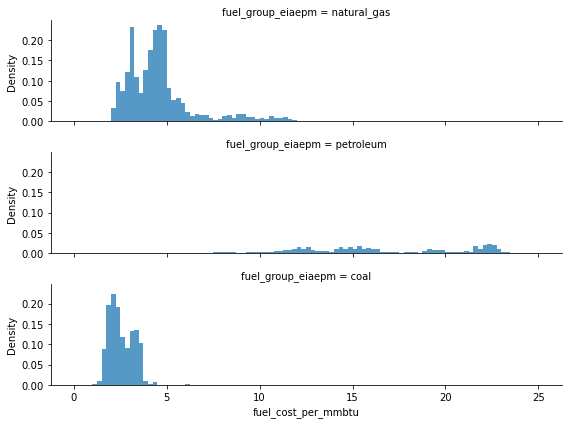

In [12]:
sns.displot(
    dude[dude.fuel_group_eiaepm.isin(["coal", "petroleum", "natural_gas"])],
    x="fuel_cost_per_mmbtu",
    row="fuel_group_eiaepm",
    bins=100,
    binrange=(0,25),
    height=2,
    aspect=4,
    linewidth=0,
    stat="density",
);

## Grid Search Cross Validation
* This seems to let us try several different sets of hyperparameters automatically.
* However, `params` can't seem to acommodate the `sample_weight` input.

In [13]:
%%time
params = {
    "hist_gbr__max_depth": [3, 8],
    "hist_gbr__max_leaf_nodes": [7, 31],
    "hist_gbr__learning_rate": [0.1, 1.0],
}
search = GridSearchCV(pipe, params)
results = cross_validate(
    search,
    X=frc_train_test[cat_cols+num_cols],
    y=frc_target,
    cv=KFold(n_splits=4, shuffle=True, random_state=0),
    n_jobs=-1,
)

/home/zane/mambaforge/envs/pudl-dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/zane/mambaforge/envs/pudl-dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/zane/mambaforge/envs/pudl-dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/zane/mambaforge/envs/pudl-dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature 

CPU times: user 343 ms, sys: 188 ms, total: 532 ms
Wall time: 1min 11s


In [14]:
pd.DataFrame(results)

,fit_time,score_time,test_score
0,68.294542,0.614358,0.009573
1,67.005094,0.152558,-0.043609
2,59.405711,0.465251,0.000623
3,63.397219,0.315258,-0.006048


## Weighting Samples
* Using `cross_val_score` it's possible to pass in the sample weights.

In [15]:
%%time
from sklearn.model_selection import cross_val_score

test_scores = cross_val_score(
    pipe,
    X=frc_train_test[cat_cols+num_cols],
    y=frc_target,
    cv=KFold(n_splits=16, shuffle=True, random_state=0),
    n_jobs=-1,
    fit_params={"hist_gbr__sample_weight": sample_weight},
)
    
print(f"mean={test_scores.mean()}, stddev={test_scores.std()}")

/home/zane/mambaforge/envs/pudl-dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/zane/mambaforge/envs/pudl-dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/zane/mambaforge/envs/pudl-dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/zane/mambaforge/envs/pudl-dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature 

mean=0.00036319929042919613, stddev=0.0008569762332843248
CPU times: user 767 ms, sys: 156 ms, total: 923 ms
Wall time: 33.4 s


In [16]:
test_scores.mean(), test_scores.std()

(0.00036319929042919613, 0.0008569762332843248)